<a href="https://colab.research.google.com/github/gustavoravel/data_science_portfolio/blob/main/Churn_Prediction_for_a_Telecom_Company.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais baixo que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#for encoding
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

#for predictions
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN

%matplotlib inline
sns.set()

In [2]:
# import data
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# drop id, it is just a number given to identify each customer
df.drop('customerID', axis=1, inplace=True)

# 5 first entries
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##Entendendo o Churn Prediction

Taxa de Rotatividade, do inglês Churn Rate, é a porcentagem anual na qual os clientes param de assinar um serviço ou os funcionários deixam o emprego.

Sabemos que para as espresas esses números são significativos, pois impactam diretamente em suas receitas. O que levam a utilizarem campanhas de retenção e engajamento com o produto ou serviço e manter o cliente em sua base.

Neste projeto entenderemos como os dados gerados pelos consumidores de um serviço de telecomunicação podem ajudar a prever próximos possíveis candidatos ao cancelamento.

Com um pedaço dos dados que foram mostrados acima, já podemos ter uma ideia de quais técnicas e soluções utilizar e como utilizar. 

Note que a base de dados já nos diz, na coluna "Churn", se o cliente já abandonou ou não o serviço de telefonia. Em casos como esse podemos usar a abordagem de aprendizado de máquina supervisionado, haja visto termos a variável alvo, e faremos nossa solução "aprender" com os dados.
Para avaliar a precisão do nosso modelo de aprendizagem de máquina, primeiro avaliaremos o balanço das informações de abandono fornecidas, e escolheremos nos basear em métricas de acurácia (accuracy), precisão (precision) e recordação (recall). A precisão mínima vai depender de cada uma das métricas. Não há uma regra.

##Exploração dos dados

Antes de iniciar a construção do nosso modelo, vamos fazer uma análise exploratória dos dados que nos foram fornecidos, para entender melhor como realizaremos nossa abordagem.

In [3]:
#general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


###Dicionário de Dados

<table>
  <tr>
    <th>Data</th>
    <th>Type</th>
    <th>Content</th>
  </tr>
  <tr>
    <td>gender</td>
    <td>boolean</td>
    <td>Sexo do cliente: Masculino, Feminino</td>
  </tr>
  <tr>
    <td>SeniorCitizen</td>
    <td>boolean</td>
    <td>Indica se o cliente tem 65 anos ou mais: Sim, Não</td>
  </tr>
  <tr>
    <td>Partner</td>
    <td>boolean</td>
    <td>Indica se o cliente é casado: Sim, Não</td>
  </tr>
  <tr>
    <td>Dependents</td>
    <td>boolean</td>
    <td>Indica se o cliente mora com algum dependente: Sim, Não. Podem ser filhos, pais, avós, etc.</td>
  </tr>
  <tr>
    <td>tenure</td>
    <td>int</td>
    <td>Indica a quantidade total de meses que o cliente está com a empresa até o final do trimestre</td>
  </tr>
  <tr>
    <td>PhoneService</td>
    <td>boolean</td>
    <td>Indica se o cliente assina serviço de telefonia residencial com a empresa: Sim, Não</td>
  </tr>
  <tr>
    <td>MultipleLines</td>
    <td>text</td>
    <td>Indica se o cliente é assinante de várias linhas telefônicas da empresa: Sim, Não</td>
  </tr>
  <tr>
    <td>InternetService</td>
    <td>text</td>
    <td>Indica se o cliente é assinante de serviço de Internet com a empresa: Não, DSL, Fibra Ótica, Cabo.</td>
  </tr>
  <tr>
    <td>OnlineSecurity</td>
    <td>boolean</td>
    <td>Indica se o cliente assina um serviço de segurança online adicional fornecido pela empresa: Sim, Não</td>
  </tr>
  <tr>
    <td>OnlineBackup</td>
    <td>boolean</td>
    <td>Indica se o cliente assina um serviço de backup online adicional fornecido pela empresa: Sim, Não</td>
  </tr>
  <tr>
    <td>DeviceProtection</td>
    <td>boolean</td>
    <td>Indica se o cliente assina um plano de proteção de dispositivo adicional para seu equipamento de Internet fornecido pela empresa: Sim, Não</td>
  </tr>
  <tr>
    <td>TechSupport</td>
    <td>boolean</td>
    <td>Indica se o cliente assina um plano adicional de suporte técnico da empresa com tempos de espera reduzidos: Sim, Não</td>
  </tr>
  <tr>
    <td>StreamingTV</td>
    <td>boolean</td>
    <td>Indica se o cliente usa seu serviço de Internet para transmitir programação de televisão de um provedor terceirizado: Sim, Não</td>
  </tr>
  <tr>
    <td>StreamingMovies</td>
    <td>boolean</td>
    <td>Indica se o cliente usa seu serviço de Internet para transmitir filmes de um provedor terceirizado: Sim, Não</td>
  </tr>
  <tr>
    <td>Contract</td>
    <td>text</td>
    <td>Indica o tipo de contrato atual do cliente: mensal, anual, bienal.</td>
  </tr>
  <tr>
    <td>PaperlessBilling</td>
    <td>boolean</td>
    <td>Indica se o cliente escolheu o boleto impresso: Sim, Não</td>
  </tr>
  <tr>
    <td>PaymentMethod</td>
    <td>boolean</td>
    <td>Indica como o cliente paga sua fatura: débito em conta, cartão de crédito, cheque enviado</td>
  </tr>
  <tr>
    <td>MonthlyCharges</td>
    <td>float</td>
    <td>Indica a cobrança mensal total atual do cliente por todos os seus serviços da empresa.</td>
  </tr>
  <tr>
    <td>TotalCharges</td>
    <td>float</td>
    <td>Indica as cobranças totais do cliente, calculadas ao final do trimestre</td>
  </tr>
  <tr>
    <td>Churn</td>
    <td>boolean</td>
    <td>Sim = o cliente saiu da empresa neste trimestre. Não = o cliente permaneceu na empresa.</td>
  </tr>
</table>

fonte: [Telco customer churn](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)


In [4]:
df.shape

(7043, 20)

O conjunto de dados da Telco contém 7043 linhas, ou seja, clientes e 20 colunas, ou seja, variáveis.

19 são variáveis preditivas e 1 é a variável alvo: `Churn`

###Variável Alvo

Vamos começar explorando a distribuição de classes de clientes que abandonaram e ainda permanecem com o serviço:

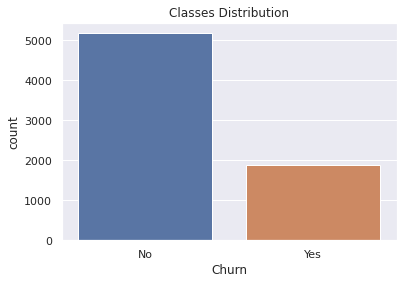



No     0.73463
Yes    0.26537
Name: Churn, dtype: float64


In [5]:
sns.countplot(x='Churn', data=df)
plt.title('Classes Distribution')
plt.show()
print('\n')
print(df['Churn'].value_counts(normalize=True))

A taxa de rotatividade dos clientes no conjunto de dados é de 26,57%, um pouco mais de 1/4 (um quarto).

###Variáveis Preditivas

Para termos uma visualização mais econômica e completa, vamos agrupar as variáveis por tipo. 

In [6]:
#investigate total charges
df['TotalCharges'].value_counts()

           11
20.2       11
19.75       9
19.65       8
19.9        8
           ..
2575.45     1
1198.8      1
152.95      1
6449.15     1
936.7       1
Name: TotalCharges, Length: 6531, dtype: int64

In [7]:
df[df['TotalCharges'] == ' ']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


Ao investigar o por quê da variável `TotalCharges` conter 11 valores com dois espaços em branco "  ", vemos que são de novos clientes, `tenure = 0`,  e nenhum deles cancelou ainda, `Churn = No`. Nesse caso temos 3 opções:

1.   Zerar a variável, substituindo os espaços em branco por 0 (haja visto sua recém chegada ainda não ter gerado custos);
2.   Repassar os valores contidos em `MonthlyCharges` (por ser algo que vai mudar conforme o tempo, haja visto o valor total ser calculado no final do trimestre), ou 
3.   Remover esses clientes da base de dados (por serem novos clientes e não exercerem influencia direta na análise de abandono, e sua quantidade não impactar diretamente no dataset).

As duas peimeiras opções, embora viáveis, podem causar algum viés no modelo e atrapalhar a aprendizagem, pois teríamos valores imputados que influenciariam nos cálculos estatísticos do modelo.

Vamos ficar com a terceira opção.


In [8]:
df.drop(df[df['TotalCharges'] == ' '].index, inplace=True)
df['TotalCharges'] = df['TotalCharges'].astype('float64')

Agora sim, sigamos aos agrupamentos.

In [9]:
cat_vars = [var for var in df.columns if df[var].dtype == 'O' and var != 'Churn']
# although it is int, SeniorCitizen is a categorical variable.
cat_vars = cat_vars + ['SeniorCitizen']
cat_vars

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [10]:
# cast all variables as categorical
df[cat_vars] = df[cat_vars].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   SeniorCitizen     7032 non-null   category
 2   Partner           7032 non-null   category
 3   Dependents        7032 non-null   category
 4   tenure            7032 non-null   int64   
 5   PhoneService      7032 non-null   category
 6   MultipleLines     7032 non-null   category
 7   InternetService   7032 non-null   category
 8   OnlineSecurity    7032 non-null   category
 9   OnlineBackup      7032 non-null   category
 10  DeviceProtection  7032 non-null   category
 11  TechSupport       7032 non-null   category
 12  StreamingTV       7032 non-null   category
 13  StreamingMovies   7032 non-null   category
 14  Contract          7032 non-null   category
 15  PaperlessBilling  7032 non-null   category
 16  PaymentMethod     7032 n

In [11]:
# now the numeric variables
num_vars = [var for var in df.columns if var not in cat_vars and var != 'Churn']
num_vars

['tenure', 'MonthlyCharges', 'TotalCharges']

Agora que separamos categoricamente nossas variávies, vamos analisar separadamente, a iniciar das numéricas, com informações estatísticas sobre as mesmas.

In [12]:
df[num_vars].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


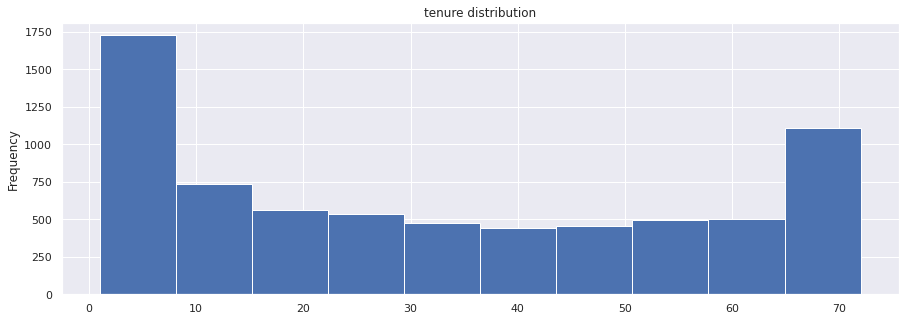

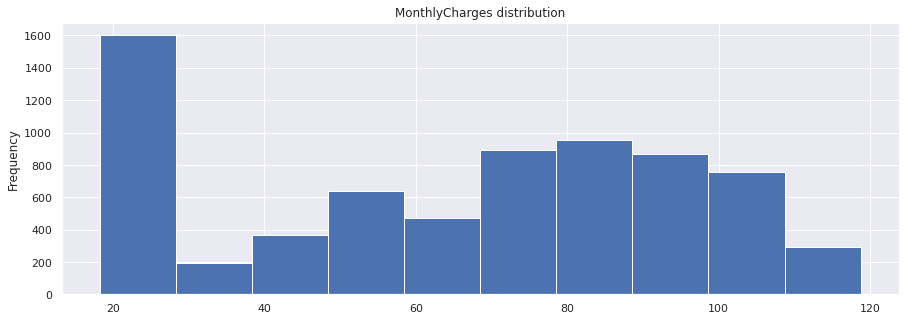

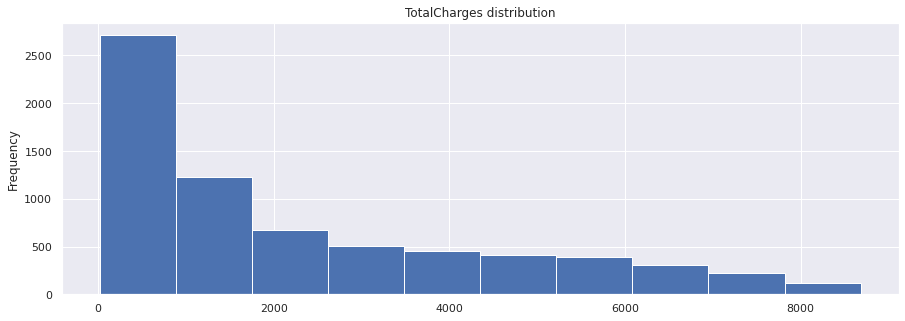

In [13]:
for var in num_vars:
  fig_dims = (15, 5)
  fig, ax = plt.subplots(figsize=fig_dims)
  df[var].plot(kind='hist')
  plt.title(var + ' distribution')
  plt.show()
  print('\n')

Como as variáveis categóricas não possuem número em sua composição, vamos fazer a contagem das mesmas e comparar sua proporcionalidade.

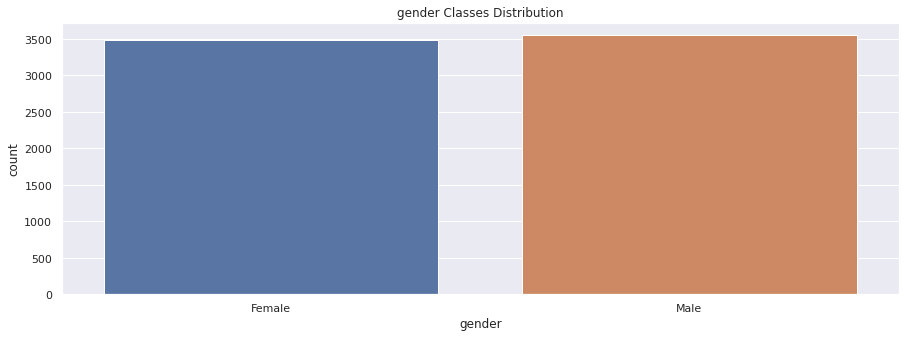

Male      0.504693
Female    0.495307
Name: gender, dtype: float64




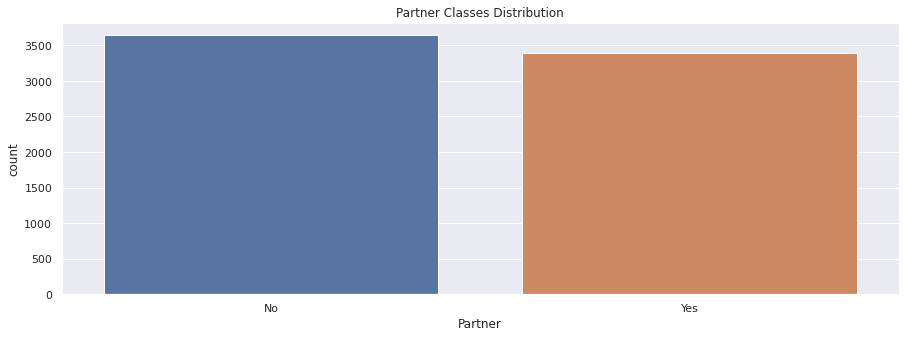

No     0.517491
Yes    0.482509
Name: Partner, dtype: float64




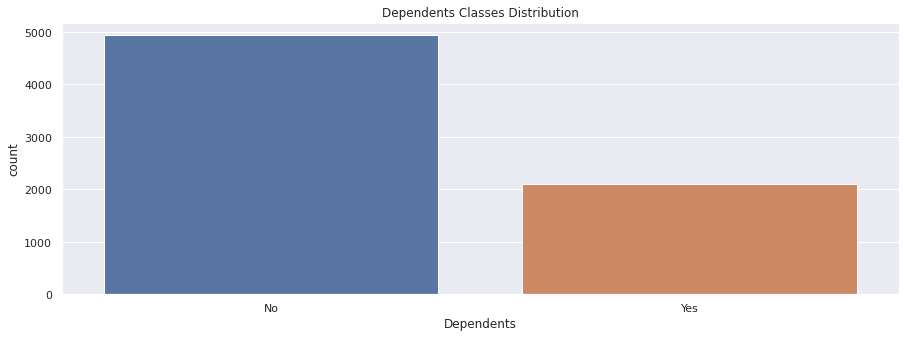

No     0.701507
Yes    0.298493
Name: Dependents, dtype: float64




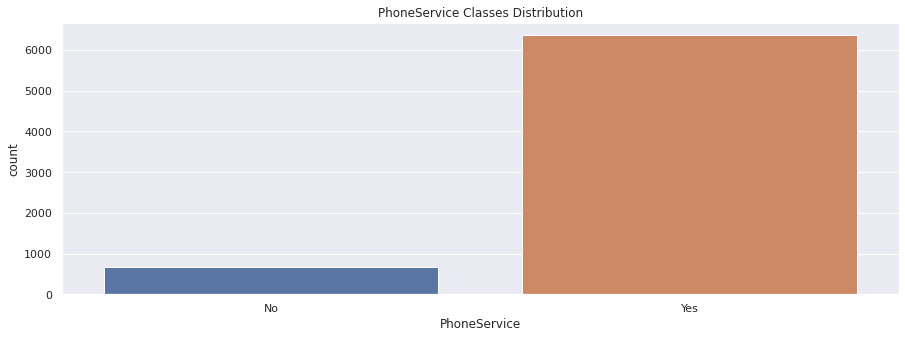

Yes    0.903299
No     0.096701
Name: PhoneService, dtype: float64




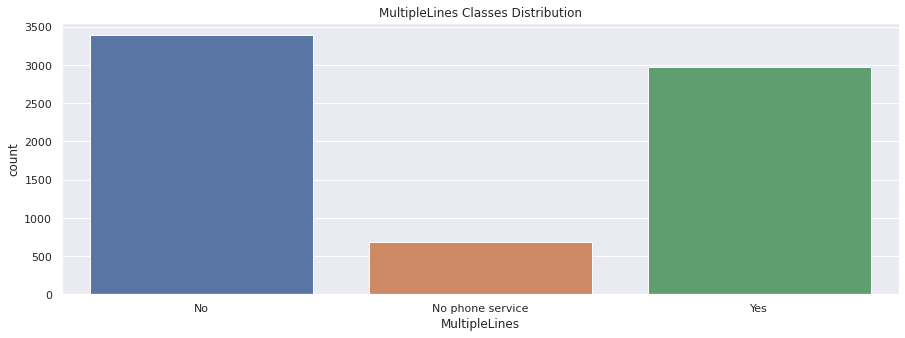

No                  0.481371
Yes                 0.421928
No phone service    0.096701
Name: MultipleLines, dtype: float64




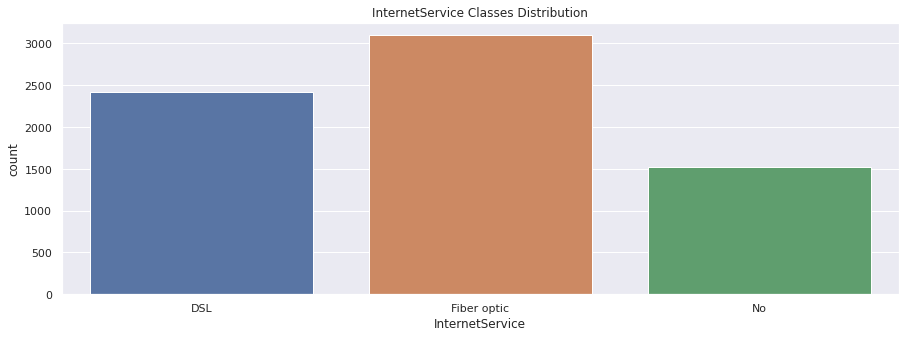

Fiber optic    0.440273
DSL            0.343572
No             0.216155
Name: InternetService, dtype: float64




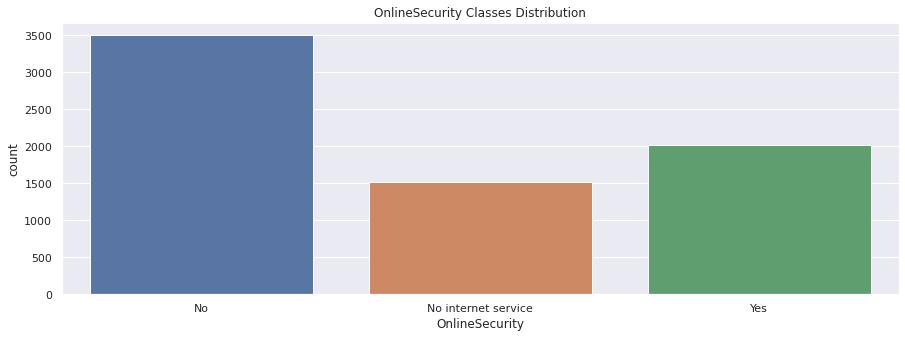

No                     0.497298
Yes                    0.286547
No internet service    0.216155
Name: OnlineSecurity, dtype: float64




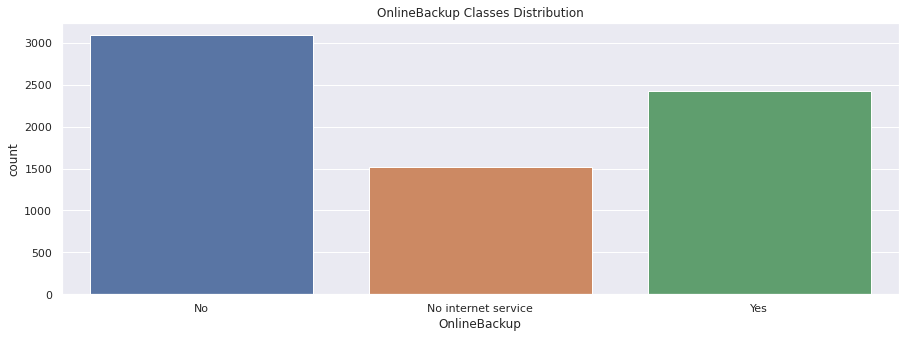

No                     0.438993
Yes                    0.344852
No internet service    0.216155
Name: OnlineBackup, dtype: float64




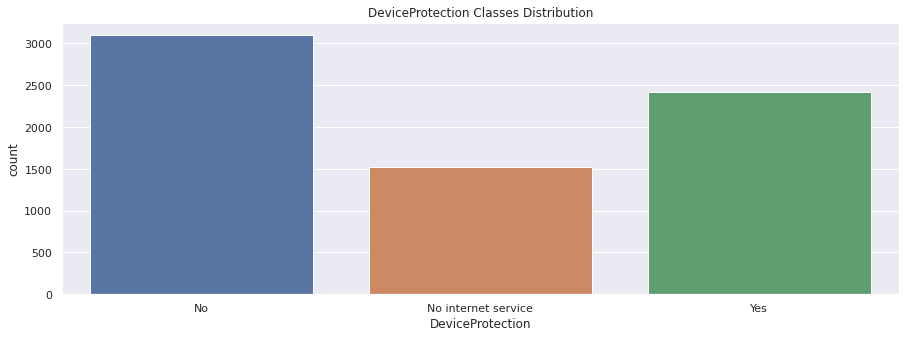

No                     0.439989
Yes                    0.343857
No internet service    0.216155
Name: DeviceProtection, dtype: float64




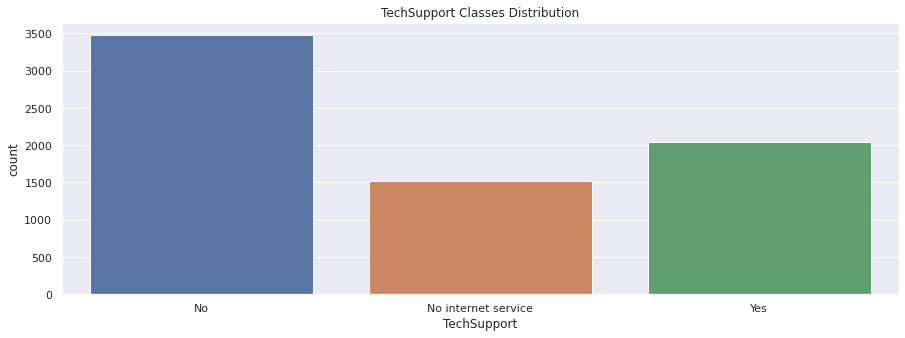

No                     0.493743
Yes                    0.290102
No internet service    0.216155
Name: TechSupport, dtype: float64




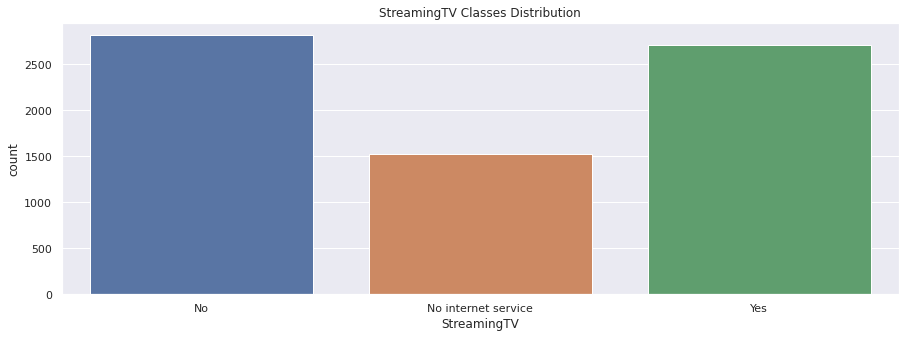

No                     0.399460
Yes                    0.384386
No internet service    0.216155
Name: StreamingTV, dtype: float64




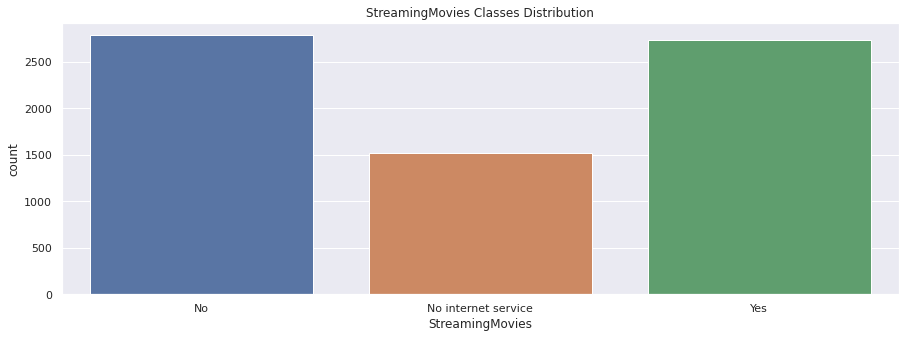

No                     0.395478
Yes                    0.388367
No internet service    0.216155
Name: StreamingMovies, dtype: float64




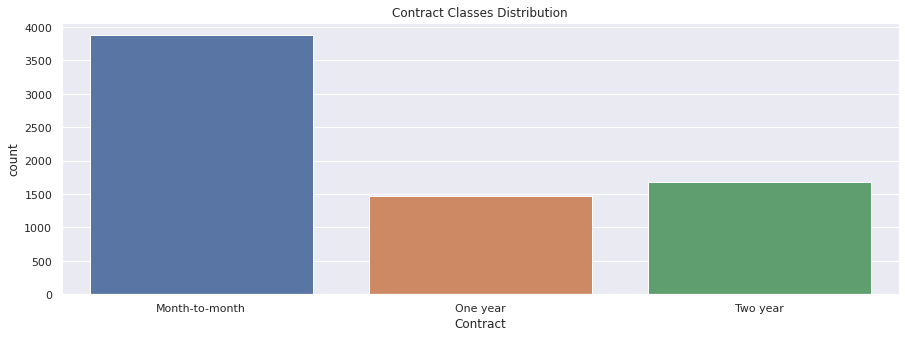

Month-to-month    0.551052
Two year          0.239619
One year          0.209329
Name: Contract, dtype: float64




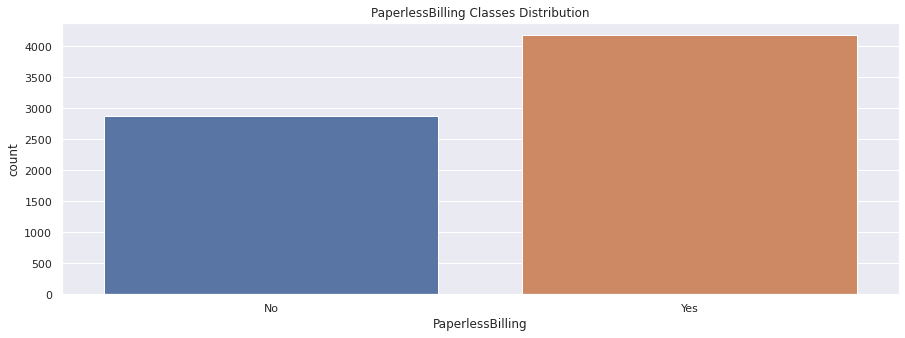

Yes    0.592719
No     0.407281
Name: PaperlessBilling, dtype: float64




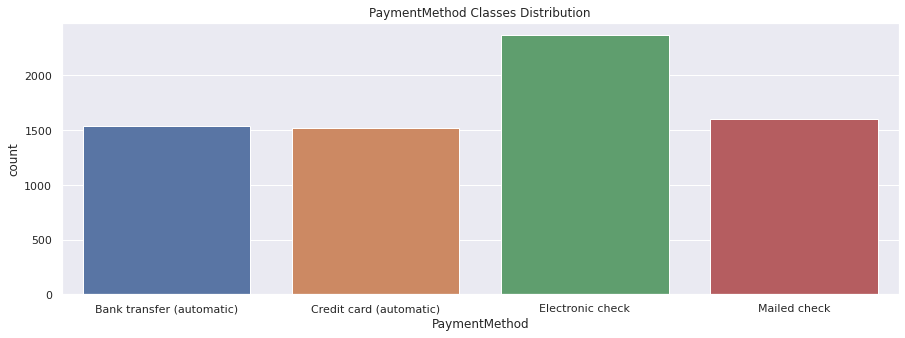

Electronic check             0.336320
Mailed check                 0.228100
Bank transfer (automatic)    0.219283
Credit card (automatic)      0.216297
Name: PaymentMethod, dtype: float64




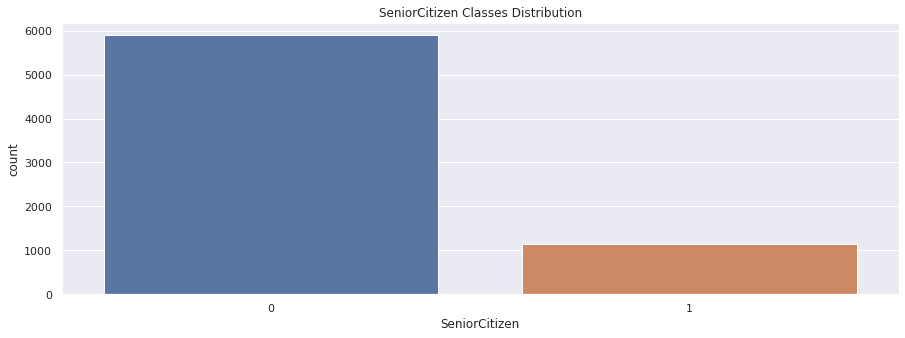

0    0.8376
1    0.1624
Name: SeniorCitizen, dtype: float64




In [14]:
for var in cat_vars:
  fig_dims = (15, 5)
  fig, ax = plt.subplots(figsize=fig_dims)
  sns.countplot(x=var, data=df, ax=ax)
  plt.title(var + ' Classes Distribution')
  plt.show()
  print(df[var].value_counts(normalize=True))
  print('\n')

Resumidamente, os gráficos plotados, tanto para as variáveis numéricas quanto categóricas, nos mostram a distribuição de classes, para entendermos a proporção da quantidade que cada classe possui em sua varíável.

Vamos ver como elas estão distribuídas para os clientes que abandonaram o serviço.

In [15]:
df_churn = df[df['Churn'] == 'Yes']

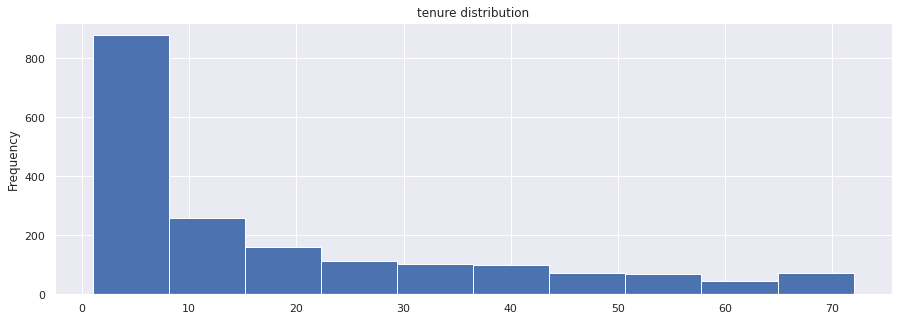

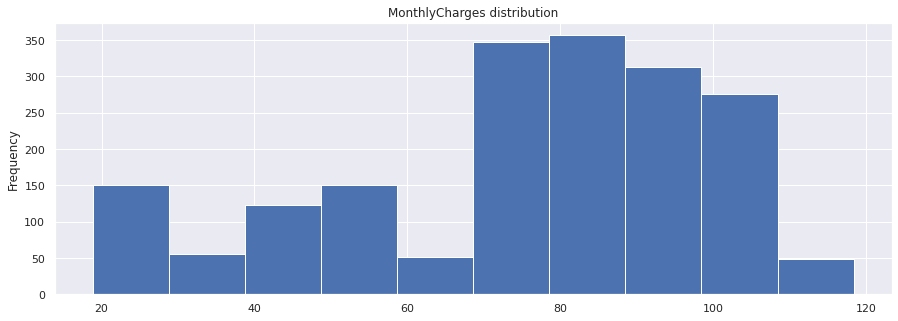

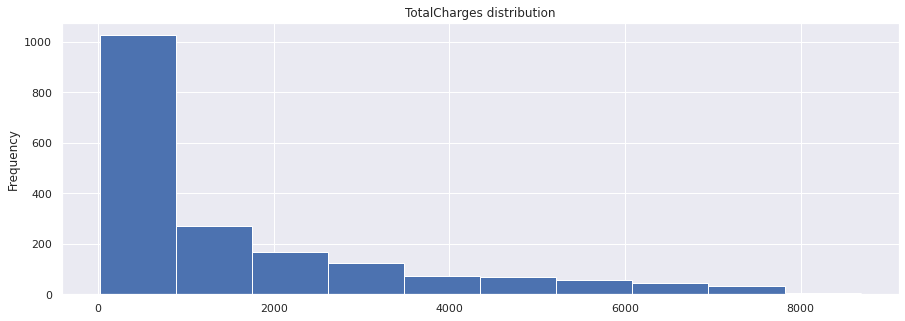

In [16]:
for var in num_vars:
  fig_dims = (15, 5)
  fig, ax = plt.subplots(figsize=fig_dims)
  df_churn[var].plot(kind='hist')
  plt.title(var + ' distribution')
  plt.show()
  print('\n')

Vemos acima que a grande maioria dos clientes com mensalidades entre \$70,00 e \$110,00, e poucos meses após a contratação (entre 0-10) tendem a abandonar mais.

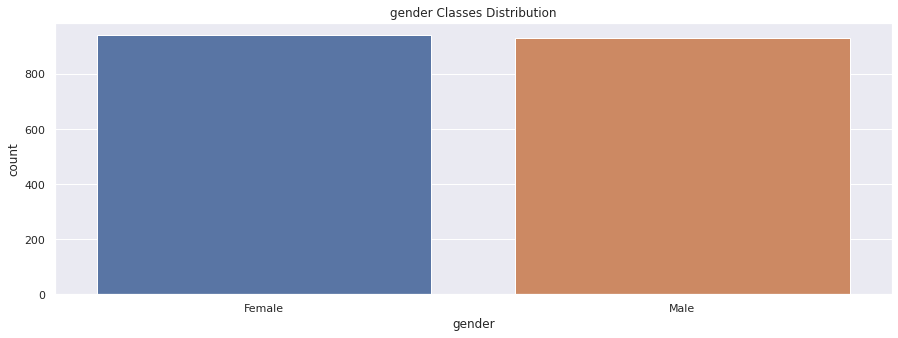

Male      0.504693
Female    0.495307
Name: gender, dtype: float64




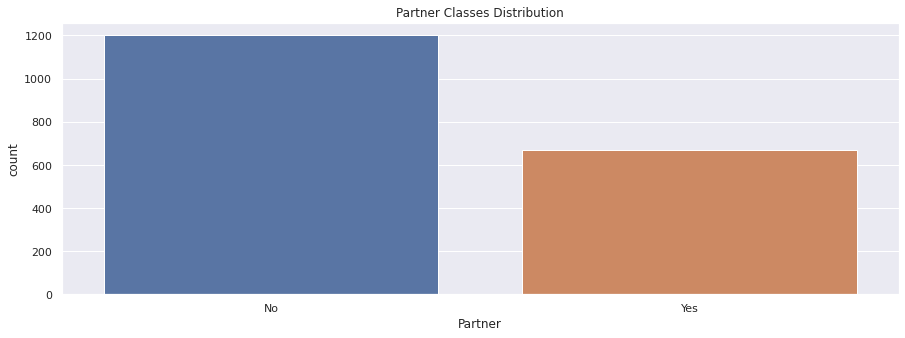

No     0.517491
Yes    0.482509
Name: Partner, dtype: float64




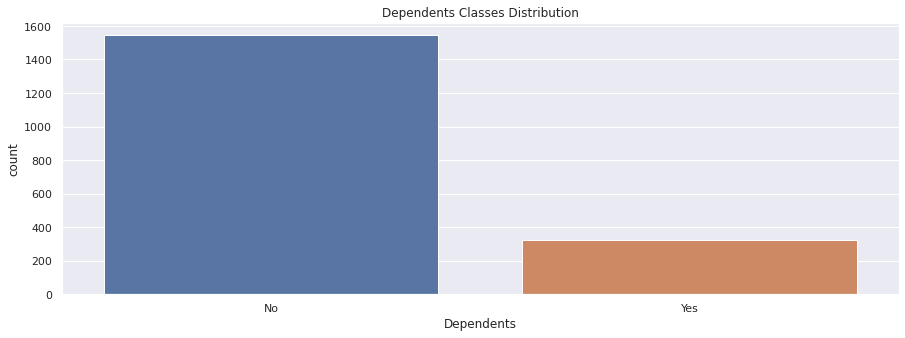

No     0.701507
Yes    0.298493
Name: Dependents, dtype: float64




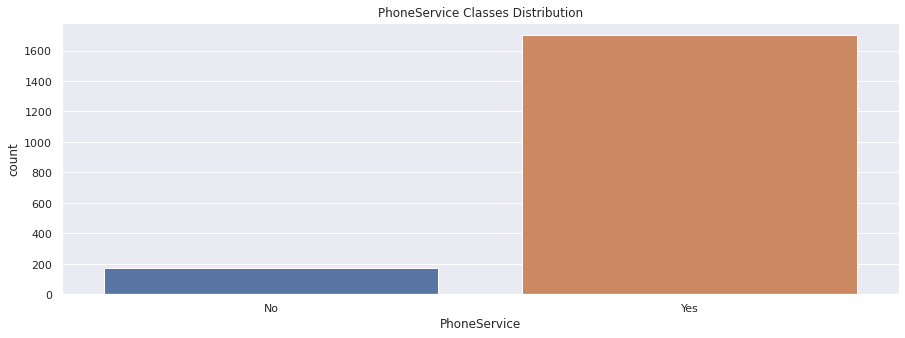

Yes    0.903299
No     0.096701
Name: PhoneService, dtype: float64




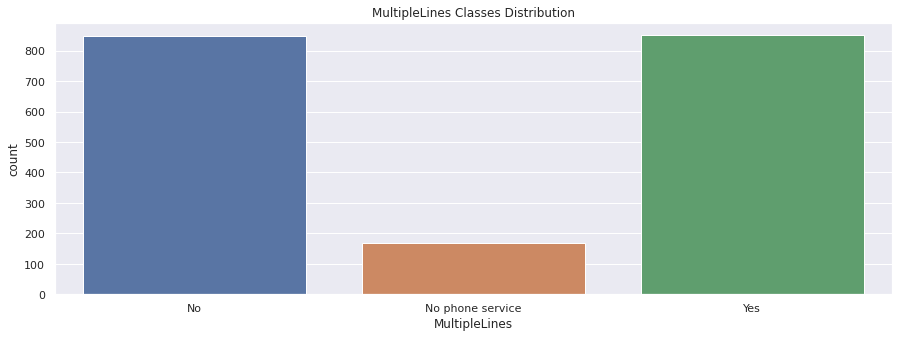

No                  0.481371
Yes                 0.421928
No phone service    0.096701
Name: MultipleLines, dtype: float64




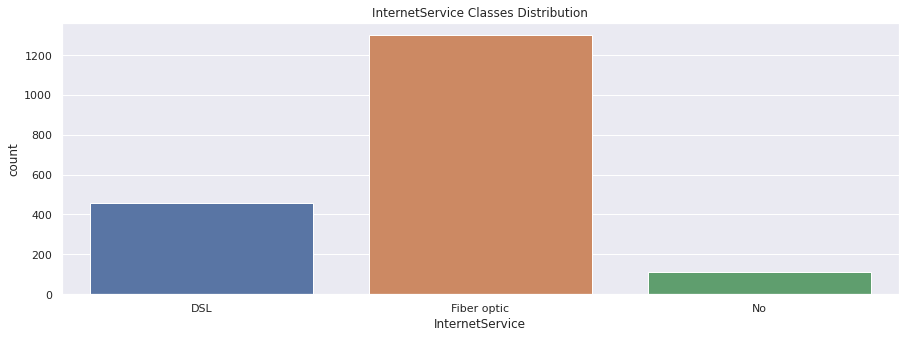

Fiber optic    0.440273
DSL            0.343572
No             0.216155
Name: InternetService, dtype: float64




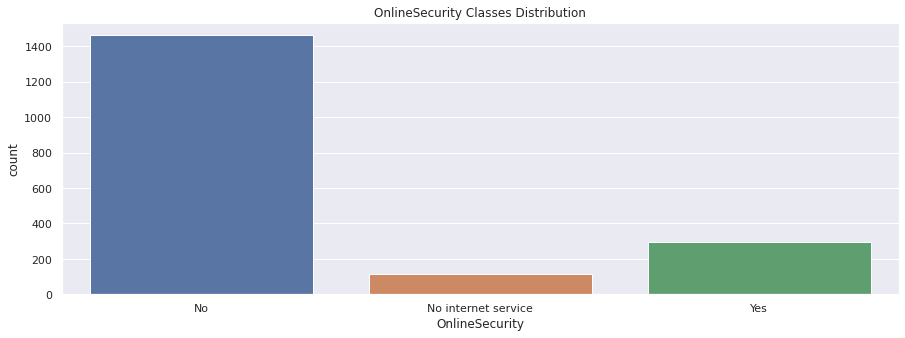

No                     0.497298
Yes                    0.286547
No internet service    0.216155
Name: OnlineSecurity, dtype: float64




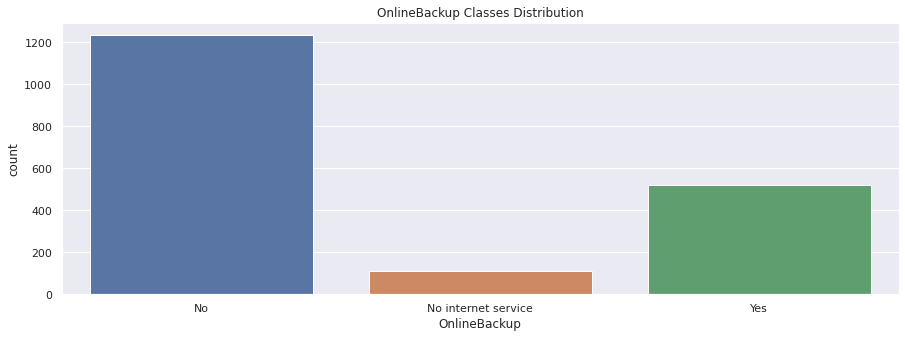

No                     0.438993
Yes                    0.344852
No internet service    0.216155
Name: OnlineBackup, dtype: float64




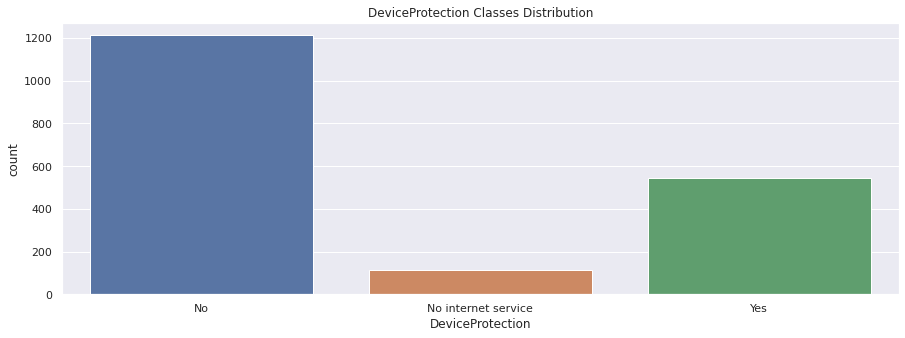

No                     0.439989
Yes                    0.343857
No internet service    0.216155
Name: DeviceProtection, dtype: float64




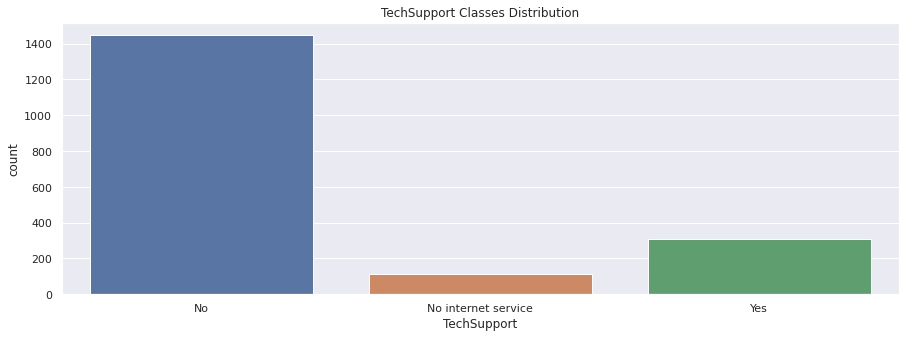

No                     0.493743
Yes                    0.290102
No internet service    0.216155
Name: TechSupport, dtype: float64




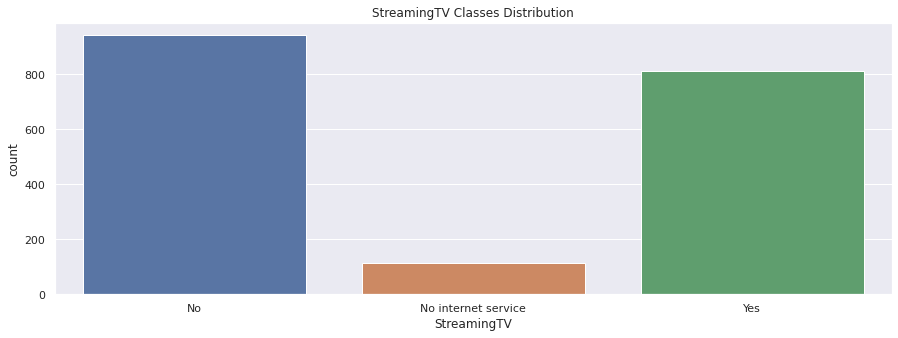

No                     0.399460
Yes                    0.384386
No internet service    0.216155
Name: StreamingTV, dtype: float64




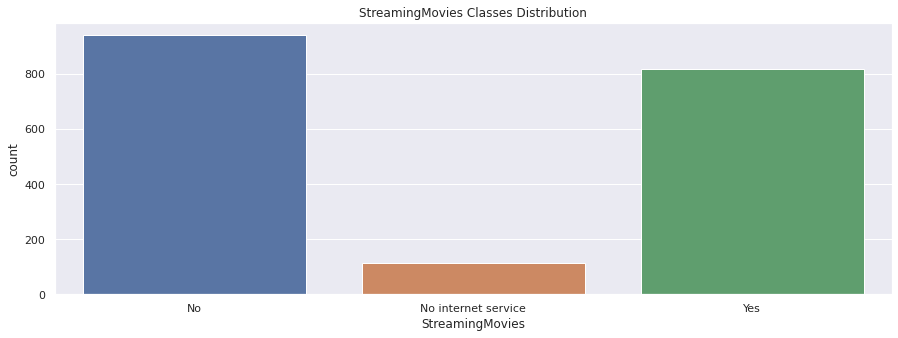

No                     0.395478
Yes                    0.388367
No internet service    0.216155
Name: StreamingMovies, dtype: float64




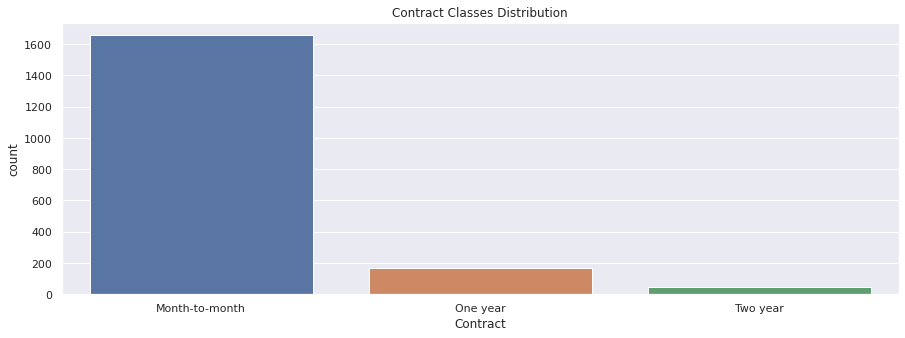

Month-to-month    0.551052
Two year          0.239619
One year          0.209329
Name: Contract, dtype: float64




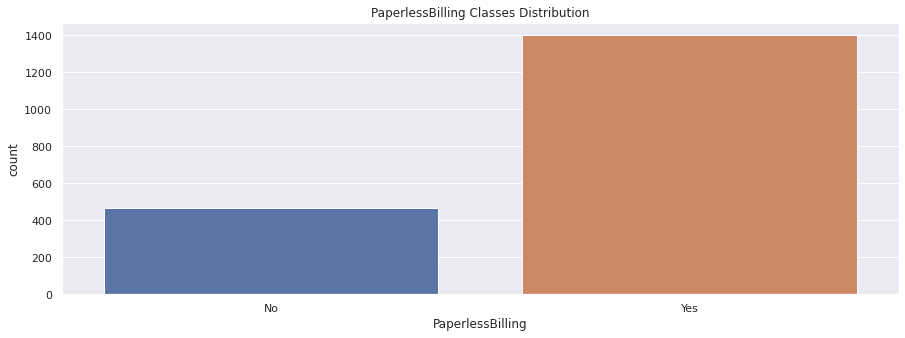

Yes    0.592719
No     0.407281
Name: PaperlessBilling, dtype: float64




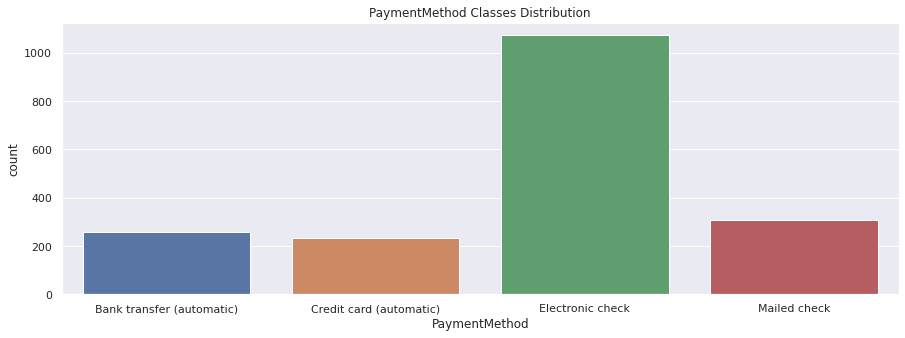

Electronic check             0.336320
Mailed check                 0.228100
Bank transfer (automatic)    0.219283
Credit card (automatic)      0.216297
Name: PaymentMethod, dtype: float64




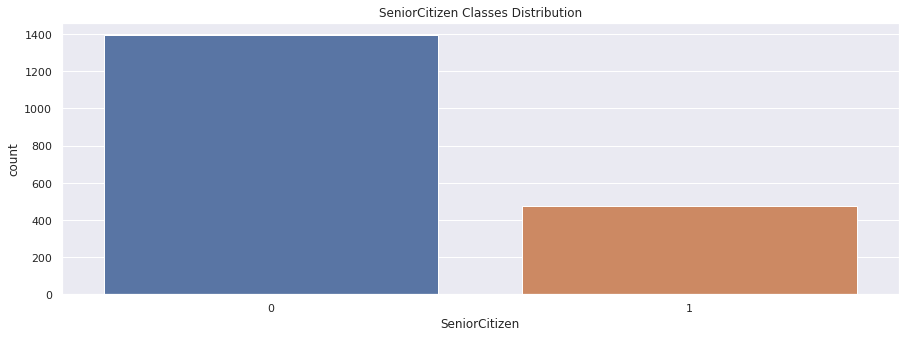

0    0.8376
1    0.1624
Name: SeniorCitizen, dtype: float64




In [17]:
for var in cat_vars:
  fig_dims = (15, 5)
  fig, ax = plt.subplots(figsize=fig_dims)
  sns.countplot(x=var, data=df_churn, ax=ax)
  plt.title(var + ' Classes Distribution')
  plt.show()
  print(df[var].value_counts(normalize=True))
  print('\n')

Na comparação acima, vemos que o sexo do cliente não influencia muito, porém, as pessoas que estão com eles sim! Veja a facilidade em abandonar o serviços em pessoas que não possuem um cônjuje ou um dependente. Vemos também a influência dos benefícios. Clientes que não possuem serviços adicionais tendem a abandonar com mais facilidade. 

##Preparação dos Dados

Para facilitar o trabalho do nosso modelo, vamos converter para números as variáveis categóricas de 2 classes, pivotar as variáveis categóricas de 3 classes e normalizar a distribuição das variáveis numéricas. Como nossa variável alvo também é categórica, fica mais complicado correlacionar com as variáveis preditivas. Por isso vamos deixar como estão, e mais para frente, verificaremos com o nosso modelo a importância de cada uma nas previsões. 

###Feature Engineering

In [18]:
two_classes_var = [var for var in cat_vars if len(df[var].value_counts()) == 2]
two_classes_var

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'SeniorCitizen']

Essas são as nossas variáveis de duas classes. Como são valores binários (sim/não, 0/1), conseguimos facilitar o trabalho do modelo codificando as classes em 0 e 1, haja visto as bibliotecas de código se darem bem melhor com números.

In [19]:
#SeniorCitizen is already encoded, let's discard it
two_classes_var.remove('SeniorCitizen')

In [20]:
encoded_df = df.copy()
le = LabelEncoder()

for var in two_classes_var:
  encoded_df['enc_'+var] = le.fit_transform(encoded_df[var])
  encoded_df = encoded_df.drop(var, axis=1)
encoded_df.columns

Index(['SeniorCitizen', 'tenure', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'enc_gender', 'enc_Partner',
       'enc_Dependents', 'enc_PhoneService', 'enc_PaperlessBilling'],
      dtype='object')

In [21]:
encoded_df['Churn'] = le.fit_transform(encoded_df['Churn'])
#no=0, yes=1

Agora para as variáveis multiclasse, não podemos simplesmente codificar para valores fixos (0, 1, 2, 3...), pois isso seria interpretado como uma ordem de importância pelo modelo e causaria viés. 

O processo aqui é diferente, vamos fazer uma transposição das variáveis e transformá-las em colunas, e os valores prentencentes à observação (linha), será preenchido com 1, e o restante, 0. Isso é chamado de "One-Hot Encoding".

In [22]:
multiclass_var = [var for var in cat_vars if len(df[var].value_counts()) > 2]
multiclass_var

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [23]:
encoded = pd.get_dummies(encoded_df[multiclass_var], drop_first=True)
encoded_df = encoded_df.drop(multiclass_var, axis=1)
encoded_df = pd.concat([encoded_df, encoded], axis=1)

Nossas variáveis preditivas numéricas merecem um outro tipo de tratamento especial. Para capturar as mudanças relativas, a magnitude da mudança e manter tudo em uma escala, precisamos normalizá-las ou padronizá-las. Isso facilita o entendimento do modelo quanto à percepção da realidade que ele está inserido.

Para a variável discreta, como `tenure`, vamos inseri-la em uma escala de proporção mínima e máxima quanto aos valores que ela possui.

As outras duas variáveis contínuas, `MonthlyCharges` e `TotalCharges`, vamoes centralizar recursos em torno de 0 e transformar em variação de unidade, (Standard Scale).

In [24]:
scaler = MinMaxScaler()
encoded_df['scaled_tenure'] = scaler.fit_transform(encoded_df[['tenure']])
encoded_df = encoded_df.drop('tenure', axis=1)
encoded_df['scaled_tenure']

0       0.000000
1       0.464789
2       0.014085
3       0.619718
4       0.014085
          ...   
7038    0.323944
7039    1.000000
7040    0.140845
7041    0.042254
7042    0.915493
Name: scaled_tenure, Length: 7032, dtype: float64

In [25]:
scaler_2 = StandardScaler()

for var in ['MonthlyCharges', 'TotalCharges']:
  encoded_df['scaled_'+var] = scaler_2.fit_transform(encoded_df[var].values.reshape(-1, 1))

encoded_df = encoded_df.drop(['MonthlyCharges', 'TotalCharges'], axis=1)

Basicamente, o dataset transformado que nosso modelo vai trabalhar ficou assim:

In [26]:
encoded_df

,SeniorCitizen,Churn,enc_gender,enc_Partner,enc_Dependents,enc_PhoneService,enc_PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,scaled_tenure,scaled_MonthlyCharges,scaled_TotalCharges
0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000,-1.161694,-0.994194
1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0.464789,-0.260878,-0.173740
2,0,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.014085,-0.363923,-0.959649
3,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0.619718,-0.747850,-0.195248
4,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.014085,0.196178,-0.940457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,1,0.323944,0.664868,-0.129180
7039,0,0,0,1,1,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,0,1.000000,1.276493,2.241056
7040,0,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.140845,-1.170004,-0.854514
7041,1,1,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.042254,0.319168,-0.872095


Agora vamos separá-los em partes de Treino, Validação e Teste (70:15:15), e seguir com as predições.

In [27]:
X = encoded_df.drop(columns = ['Churn']).copy()
y = encoded_df['Churn']

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)
print(X_test.shape), print(y_test.shape)

(4922, 30)
(4922,)
(1055, 30)
(1055,)
(1055, 30)
(1055,)


(None, None)

###Criação e treinamento do modelo

Nossos dados já estão divididos, vamos iniciar o treinamento do modelo para ele aprender os padrões dos cliente que abandonam os serviços, comparar os resultados das predições com os dados separados para os testes e validações e ajustar parâmetros caso necessário.

Como mencionado no começo do artigo, usaremos a aprendizagem de máquina supervisionada para solucionar o problema, e para isso contamos com 3 candidatos de modelos, que possuem abordagens diferentes, para nos ajudar:



*   Logistic Regression (Regressão Logística):

      A regressão logística é um algoritmo de classificação de aprendizado de máquina usado para prever a probabilidade de uma variável dependente categórica. Na regressão logística, a variável dependente é uma variável binária que contém dados codificados como 1 (sim, sucesso, etc.) ou 0 (não, falha, etc.).


*   K Nearest Neighbours (Vizinhos Próximos "K"):

      O algoritmo KNN assume que coisas semelhantes existem nas proximidades. Em outras palavras, coisas semelhantes estão próximas umas das outras.

      
*   Decision Tree Classifier (Classificador de Árvore de Decisão):

      A estrutura da árvore de decisão é simples - ela divide hierarquicamente os dados em subconjuntos que são novamente divididos em partições ou ramos menores até que se tornem “puros”, o que significa que todos os recursos dentro do ramo pertencem à mesma classe. Essas classes são chamadas de “folhas”.





In [28]:
SEED = 1

lr = LogisticRegression(random_state=SEED)
knn = KNN()
dt = DecisionTreeClassifier(random_state=SEED)

# Define a list called classifier that contains the tuples (classifier_name, classifier)
classifiers = [('Logistic Regression', lr),
('K Nearest Neighbours', knn),
('Classification Tree', dt)]

In [29]:
# Iterate over the defined list of tuples containing the classifiers
for clf_name, clf in classifiers:

  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_val)

  # Evaluate the accuracy of clf on the validation set
  print('{:s}: {:.3f}'.format(clf_name, accuracy_score(y_val, y_pred)))

Logistic Regression: 0.800
K Nearest Neighbours: 0.755
Classification Tree: 0.723


Ótimo! Apenas com o classificador sem nenhum parâmetro configurado, vimos através da métrica de acurácia que a regressão logística possui uma melhor adaptação aos dados. Vamos seguir com ele daqui para frente, pela facilidade de se explorar as oportunidades. A partir daqui, podemos: reduzir a dimensionalidade do dataset, ficando apenas com as variáveis mais relevantes para o modelo, e ajustar os hiperparâmetros, configurações na criação do modelo que visam mudar seu comportamento durante o aprendizado.

Text(0.5, 1.0, 'Feature Importance')

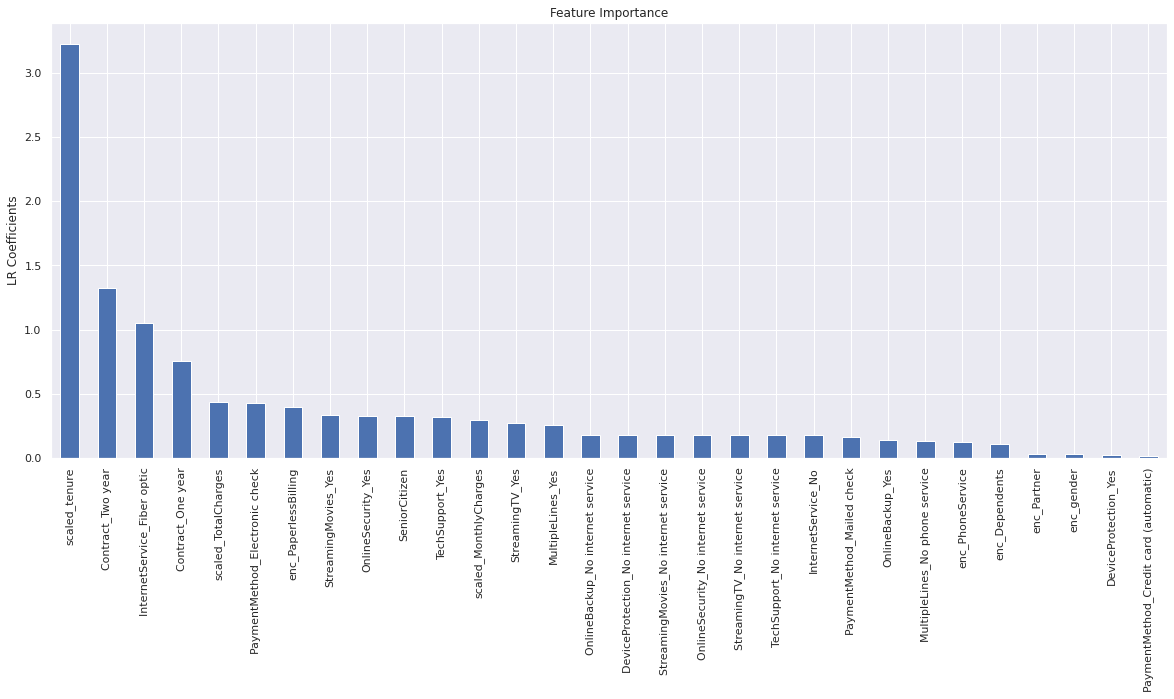

In [30]:
#feature importance

importance = pd.Series(np.abs(lr.coef_.ravel()))
importance.index = X_train.columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(20, 8))
plt.ylabel('LR Coefficients')
plt.title('Feature Importance')

Acabamos de ver no gráfico acima (importância das variáveis) que o tempo de casa é o principal influenciador das decisões do modelo. Se quiséssemos economizar recursos, poderíamos 5 variáveis do conjunto de dados. Mas esse cenário ainda pode mudar. E além do mais, elas estão codificadas, e separadas por suas categorias. 

###Ajuste de Hiperparâmetro

Hiperparâmetro é algo que você define antes do processo de modelagem. Os algoritmos não aprendem eles sozinhos. Felizmente, no modelo de regressão logística, temos poucos para ajustar. Ajustes em excesso podem fazer com que o modelo dê overfitting (simplesmente decora os dados e possui dificuldades em prever valores desconhecidos).

In [31]:
#changing solver to support other penalties
lr = LogisticRegression(max_iter=400, solver='liblinear', random_state=SEED)
params = {'C': [0.01, 0.1, 1, 10],
          'penalty': ["l1","l2"]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)

search = GridSearchCV(lr, param_grid=params, scoring='accuracy', cv=cv)
result = search.fit(X_train, y_train)

In [32]:
print('Best Score: %.3f' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.803
Best Hyperparameters: {'C': 10, 'penalty': 'l2'}


Ao realizar os ajustes, os melhores hiperparâmetros foram aqueles que já foram mantidos por padrão ao iniciar o treinamento, ou seja, não foi necessário muita perfumaria. Outros ajustes poderiam ser feitos nesse consjunto de dados, como por exemplo, feature engineering e uso do XGBoost, porém o projeto ficaria mais longo que está. Agora vamos partir para a análise dos placares.

###Validação do modelo

Para avaliar nosso modelo, vamos retreiná-lo com os melhores parâmetros e ver como ele se comporta tentando prever os dados de validação e teste separados anteriormente. 

In [33]:
lr = LogisticRegression(penalty='l1', C=10, max_iter=400, solver='liblinear', random_state=SEED)
lr.fit(X_train, y_train)
y_val_pred = lr.predict(X_val)

In [34]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       765
           1       0.64      0.58      0.61       290

    accuracy                           0.79      1055
   macro avg       0.74      0.73      0.73      1055
weighted avg       0.79      0.79      0.79      1055



In [35]:
print(confusion_matrix(y_val, y_val_pred))

[[670  95]
 [122 168]]


Pelo relatório de classificação, vemos que o modelo mantém a acurácia de 80% dos dados de treinamento quando tenta prever os dados de validação.

[Neste projeto anterior](https://https://bit.ly/2MnzWkK) explico o que é a matriz de confusão. Do total de 1055 clientes testados:

*   670 realmente abandonariam o serviço, e o modelo previu;
*   95 o modelo previu que iria abandonar, sendo que realmente não;
*   122 o modelo previu que não iria abandonar, sendo que realmente sim e
*   168 não abandonariam o serviço, e o modelo previu.

Ao iniciar as ações de retenção, poderíamos excluir os 95 falso positivos e os 168 verdadeiros negativos para economizar nos esforços (custos de ofertas, envio de e-mail, etc).







##Conclusão

"Manter um cliente custa 5 a 7 vezes menos do que conquistar um novo" dizia Philip Kotler, um grande visionário consultor de Marketing.

Investir no relacionamento com os clientes que já possuímos tem sido o alvo para para trabalhar sua fidelização e encantamento. Ao estudar suas atitudes, satisfação com produtos e serviços, a ciência de dados ajuda a explorar pontos fortes e fracos desse relacionamento e proporcionar a caminhada para o sucesso, que é o amor do consumidor pela marca.

Obviamente poderiamos falar aqui também que podemos utilizar os dados para oferecer o que há de melhor para o cliente com base nas informações que ele mesmo gera para nós. Mas só o fato de termos como saber se ele iria embora ou não já é um passo importante!
